In [1]:
# -*- coding:utf-8 -*-
import json
import requests
import csv,re,os,math,glob
from lxml import etree
from datetime import date,datetime
import pandas as pd
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
import hashlib #check md5sum of rawdata files

In [2]:
#Save_interest_rate

In [3]:
def save_interest_rate(data):
    
    # 1. 创建文件对象
    f = open('CB_interest_rate.csv', 'w', encoding='utf-8', newline='')
    # 2. 基于文件对象构建 csv写入对象
    csv_writer = csv.writer(f)
    # 3. 构建列表头
    csv_writer.writerow(["id","iry1", "iry2", "iry3", "iry4", "iry5", "iry6"])
    
    count = 0
    for item in data:
        count +=1
        if (count %10 == 0):
            print("processing "+str(count)+" items")
        try:
            interest = get_interest_rate(item['id'])
            interest = [item['id']]+interest
            csv_writer.writerow(interest)
        except Exception as e:
            print("Oops!", e.__class__, "occurred.")
            print("The error happed at "+item['id'])
    # 5. 关闭文件
    print("Finished processing "+str(count)+" items")
    f.close()


In [4]:
#append_interest_rate

In [5]:
def append_interest_rate(item):
    
    # 1. 创建文件对象
    interest_dict = get_interest_dict('CB_interest_rate.csv')
    if item['id'] in interest_dict:
        return
    f = open('CB_interest_rate.csv', 'a', encoding='utf-8', newline='')
    # 2. 基于文件对象构建 csv写入对象
    csv_writer = csv.writer(f)
    
    

    try:
        interest = get_interest_rate(item['id'])
        interest = [item['id']]+interest
        csv_writer.writerow(interest)
        print("Finished appending new CB "+ item['name']+" into interest rate files")
    except Exception as e:
        print("Oops!", e.__class__, "occurred.")
        print("The error happed at "+item['id'])
    
    # 5. 关闭文件
    
    f.close()


In [6]:
#get_interest_rate

In [7]:
def get_interest_rate(id):
    years = 6
    detials_url = 'https://www.jisilu.cn/data/convert_bond_detail/'+id
    detials_response = requests.get(detials_url)
    html = detials_response.content.decode("utf-8")
    html = etree.HTML(html)
    interest_text = html.xpath('.//td[@id="cpn_desc"]/text()')
    if(not interest_text[0].find('%')):
        print(" not in interest test %s %s"%(id,interest_text))
        pattern = re.compile(r'(?<!\d|\.)\d+(?:\.\d+)?')  #get proper format number
    else:
        pattern = re.compile(r'(?<!\d|\.)\d+(?:\.\d+)?\s?%')  #get proper format number
    interest = pattern.findall(interest_text[0])
    if(len(interest) <= 1):
        print("%s fixed interest rate %s"%(id, interest_text[0]))
        interest = interest*years
    elif(len(interest)<5):
        print("%s number of interest rate between 2-4 %s"%(id, interest_text[0]))
        print("You may need to check manually")
    elif(len(interest)>6):
        print("%s number of interest rate greater than 6 %s"%(id, interest_text[0]))
        print("You may need to check manually")
    interest = [rate.strip("%") for rate in interest]
    return interest

In [8]:
# get interest dict

In [9]:
def get_interest_dict(file):
    interest_dict = dict()
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            if line_count == 0:
                #skip header
                line_count += 1
            else:
                interest_dict[row[0]] = row[1:]
                line_count += 1
        print(f'Processed {line_count} lines.')
    return interest_dict


In [10]:
# buy or sell cb

In [11]:
def buy_sell_db(db_df,file,show_price=False):
    db_df = db_df[(db_df['force_redeem'] != 'Y')]
    total_number = len(db_df)
    quartile = np.percentile(db_df['db_low'],25) ##first quartile
    keep_number = int(total_number*0.1)  ##10th percentile
    buy_number  = int(total_number*0.05) ##5th percentile
    add_number = int(total_number*0.02)  ##2th percentile
    
    keep_dict = {i:db_df['name'][i] for i in db_df[0:keep_number].index}
    buy_dict = {i:db_df['name'][i] for i in db_df[0:buy_number].index}
    add_dict = {i:db_df['name'][i] for i in db_df[0:add_number].index}
    sell_count = 0
    holding_dict = dict()
    
    ##sell
    my_list = []
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            cb_id,cb_name,category = row
            if cb_id not in db_df.index:
                print("%s %s %s"%(cb_id,cb_name,'not in lists'))
                continue
            holding_dict[cb_id] = cb_name
            price = db_df.loc[cb_id]['price']
            db_low = db_df.loc[cb_id]['db_low']
            item = {'id':cb_id,'name':cb_name,'price':price,'db_low':db_low}
            my_list.append(item)
            if('db' not in category):
                continue
            if cb_id not in keep_dict.keys():
                sell = "Sell"
                if(db_low>quartile):
                    sell = "Strong Sell"
                if(show_price):
                    print("%s %s %s %s %.3f"%(sell,cb_id,cb_name,price,db_low))
                else:
                    print("%s %s %s"%(sell,cb_id,cb_name))
                sell_count += 1
    if(sell_count==0):
        print('No CB to sell')
        
    ##buy
    print()
    for cb_id,cb_name in add_dict.items():
        price = db_df.loc[cb_id]['price']
        db_low = db_df.loc[cb_id]['db_low']
        if(show_price):
            print("Add  %s %s %s %.3f"%(cb_id,cb_name,price,db_low))
        else:
            print("Add  %s %s"%(cb_id,cb_name))
    print()
    for cb_id in buy_dict.keys():
        if cb_id not in holding_dict.keys():
            price = db_df.loc[cb_id]['price']
            db_low = db_df.loc[cb_id]['db_low']
            cb_name = keep_dict[cb_id]
            if(show_price):
                print("Buy  %s %s %s %.3f"%(cb_id,cb_name,price,db_low))
            else:
                print("Buy  %s %s"%(cb_id,cb_name))
    
    my_df = pd.DataFrame(my_list)
    my_df = my_df.set_index(['id'])
    my_df = my_df.sort_values('db_low',ascending=True)
    return my_df,buy_dict
    

In [12]:
#buy sell low

In [13]:
def buy_sell_low(lp_df,db_buy_dict,file,show_price=False):
    total_number = len(lp_df)
    quartile = np.percentile(lp_df['lower_deviation'],25) ##first quartile
    keep_number = int(total_number*0.1)  ##10th percentile
    buy_number  = int(total_number*0.05) ##5th percentile
    add_number = int(total_number*0.02)  ##2th percentile
    
    keep_dict = {i:lp_df['name'][i] for i in lp_df[0:keep_number].index}
    buy_dict = {i:lp_df['name'][i] for i in lp_df[0:buy_number].index}
    add_dict = {i:lp_df['name'][i] for i in lp_df[0:add_number].index}
    sell_count = 0
    holding_dict = dict()
    
    ##sell
    my_list = []
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            cb_id,cb_name,category = row
            if cb_id not in lp_df.index:
                print("%s %s %s"%(cb_id,cb_name,'not in lists'))
                sell_count += 1
                continue
            holding_dict[cb_id] = cb_name
            price = lp_df.loc[cb_id]['price']
            db_low  = lp_df.loc[cb_id]['db_low']
            premium = lp_df.loc[cb_id]['premium']
            lower_deviation = lp_df.loc[cb_id]['lower_deviation']
            fit_price = lp_df.loc[cb_id]['fit_price']
            low_fit_price = lp_df.loc[cb_id]['low_fit_price']
            upper_fit_price = lp_df.loc[cb_id]['upper_fit_price']
            item = {'id':cb_id,'name':cb_name,'price':price,'db_low':db_low,'premium':premium,
                    'lower_deviation':lower_deviation}
            my_list.append(item)
            if cb_id not in keep_dict.keys() or price>fit_price:
                if('db' in category and price<fit_price):
                    continue
                sell = "Sell"
                if(lower_deviation>quartile or price>upper_fit_price):
                    if('db' in category and price<upper_fit_price):
                        continue
                    sell = "Strong Sell"
                if(show_price):
                    print("%s %s %s %s %.3f %.3f %.3f"
                          %(sell,cb_id,cb_name,price,db_low,premium,lower_deviation))
                else:
                    print("%s %s %s"%(sell,cb_id,cb_name))
                sell_count += 1
    if(sell_count==0):
        print('No CB to sell')
        
    ##buy
    print()
    for cb_id,cb_name in add_dict.items():
        price = lp_df.loc[cb_id]['price']
        db_low  = lp_df.loc[cb_id]['db_low']
        premium = lp_df.loc[cb_id]['premium']
        lower_deviation = lp_df.loc[cb_id]['lower_deviation']
        low_fit_price = lp_df.loc[cb_id]['low_fit_price']
        if price>=low_fit_price:
            continue
        if(show_price):
            print("Add  %s %s %s %.3f %.3f %.3f"
                  %(cb_id,cb_name,price,db_low,premium,lower_deviation))
        else:
            print("Add  %s %s"%(cb_id,cb_name))
    print()
    for cb_id,cb_name in buy_dict.items():
        price = lp_df.loc[cb_id]['price']
        db_low  = lp_df.loc[cb_id]['db_low']
        premium = lp_df.loc[cb_id]['premium']
        lower_deviation = lp_df.loc[cb_id]['lower_deviation']
        low_fit_price = lp_df.loc[cb_id]['low_fit_price']
        if cb_id in db_buy_dict.keys():
            print("Strong Buy %s %s %s %.3f %.3f %.3f"
                  %(cb_id,cb_name,price,db_low,premium,lower_deviation))
        elif cb_id not in holding_dict.keys():
            if price>=low_fit_price:
                continue
            
            if(show_price):
                print("Buy %s %s %s %.3f %.3f %.3f"
                  %(cb_id,cb_name,price,db_low,premium,lower_deviation))
            else:
                print("Buy  %s %s"%(cb_id,cb_name))
    
    #my_df = pd.DataFrame(my_list)
    #my_df = my_df.set_index(['id'])
    #my_df = my_df.sort_values('premium',ascending=True)
    #return my_df
    

In [14]:
# read historical data

In [15]:
def read_historical_data(file):
    history_list = []
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        next(csv_reader, None)  # skip the headers
        for row in csv_reader:
            history_list.append(row)
    return history_list

In [16]:
# get data

In [17]:
def get_dat():
    # Fill in your details here to be posted to the login form.
    payload = {
        'user_name': 'a39856ed4377d1b92cffb0677febf5b8',
        'password': 'ca5572b5ffe8c33746727709bc7d6c6f'
    }
    headers = {
        "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.114 Safari/537.36",
        #"User-agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.106 Safari/537.36 OPR/38.0.2220.41",
        "Cookie": "kbzw__Session=l313fggdcjpnd7eineqilm6lf4; kbz_newcookie=1; kbzw_r_uname=ijayden; Hm_lvt_164fe01b1433a19b507595a43bf58262=1627073048,1627079966,1627115858,1627117055; Hm_lpvt_164fe01b1433a19b507595a43bf58262=1627118717"
    }
    loginUrl="https://www.jisilu.cn/account/ajax/login_process/"
    r = requests.post(loginUrl,data=payload)

    newUrl ="https://www.jisilu.cn/data/cbnew/cb_list/?___jsl=LST___t=1584777951900"
    #最简单的爬虫请求.也可以加上headers字段，防止部分网址的反爬虫机制
    response = requests.get(newUrl,cookies=r.cookies)
    data = response.content.decode("utf-8")
    dat = json.loads(data)

    # 所有数据
    lst_data = []
    count = 0
    for one in dat['rows']:
        # 每一条数据
        lst_dat = dict()
        # 转债id
        id = one["id"]
        dat_cell = one["cell"]
        # 是否赎回
        is_force_redeem = dat_cell['redeem_flag']
        is_list = dat_cell['price_tips']
        
        if is_list != "待上市":
            
            count += 1
            if (count %100 == 0):
                print("processing "+str(count)+" items")
            
            # 转债名称
            name = dat_cell['bond_nm']
            # 现价
            price = dat_cell['price']
            # stock id
            stock_id = dat_cell['stock_id']
            stock_id = stock_id.replace("sh", "ss")
            stock_id = stock_id[2:]+"."+stock_id[0:2]
            # stock name
            stock_nm = dat_cell['stock_nm']
            # 溢价率
            premium_rt = dat_cell['premium_rt']
            # 评级
            rating_cd = dat_cell['rating_cd']
            
            
            # next put date
            next_put_dt = dat_cell['next_put_dt']
            # put price
            put_price   = dat_cell['put_price']
            # 回售触发价
            put_convert_price = dat_cell['put_convert_price']
            
            
            # maturity date
            maturity_dt = dat_cell['maturity_dt']
            # redeem price
            redeem_price = dat_cell['redeem_price']
            
            # 强赎触发价
            redeem_dt = dat_cell['redeem_dt']
            force_redeem_price = dat_cell['force_redeem_price']
            # 剩余时间
            last_time = dat_cell['year_left']
            pb = dat_cell['pb']


            #lst_dat.append(id)
            lst_dat['id'] = id
            lst_dat['name'] = name
            lst_dat['stock_id'] = stock_id
            lst_dat['stock_name'] = stock_nm
            lst_dat['price'] = float(price)
            lst_dat['convert_value'] = float(dat_cell['convert_value'])
            lst_dat['premium_rt'] = premium_rt
            lst_dat['rating_cd'] = rating_cd
            lst_dat['pb']  = pb
            lst_dat['convert_amt_ratio'] = dat_cell['convert_amt_ratio']
            lst_dat['convert_amt_ratio2'] = dat_cell['convert_amt_ratio2']
            
            
            
            lst_dat['next_put_dt'] = next_put_dt
            lst_dat['put_price'] = put_price
            lst_dat['put_convert_price'] = put_convert_price
            
            lst_dat['maturity_dt'] = maturity_dt
            lst_dat['redeem_price'] = redeem_price
            lst_dat['last_time'] = last_time
            lst_dat['force_redeem'] = is_force_redeem
            
            lst_dat['redeem_dt']  = redeem_dt
            lst_dat['force_redeem_price'] = force_redeem_price
            
  
            lst_data.append(lst_dat)
            
        else:
            continue
    print("Finished processing "+str(count)+" items")
    
    return lst_data

In [18]:
#put arbitrage

In [19]:
def put_arbitrage(data):
    data_copy = deepcopy(data)
    put_data = []
    count = 0
    for item in data_copy:
        price       = item['price']
        put_price   = item['put_price']

        
        if(put_price is None):
            continue
            
        price = float(price)
        put_price = float(put_price)
            
        if(price>put_price+5.0): ###To Save Time, the maximun interest could not over 10
            continue
            
        next_put_dt = item['next_put_dt']
        next_put_dt = datetime.strptime(next_put_dt,'%Y-%m-%d').date()
        maturity_dt = item['maturity_dt']
        maturity_dt = datetime.strptime(maturity_dt,'%Y-%m-%d').date()
        today = date.today()
        
        
        days_to_maturity = maturity_dt-today
        years_to_maturity = days_to_maturity.days/365
        days_to_put  = next_put_dt-today
        years_to_put  = days_to_put.days/365
        
        put_to_maturity = round(years_to_maturity-years_to_put)
        #print(put_to_maturity)
        
        
        if item['id'] in interest_dict.keys():
            interest = interest_dict[item['id']]
        else:
            append_interest_rate(item)
            interest = get_interest_rate(item['id'])
        
        
        total_interest = 0
        for i in range(3,math.ceil(years_to_put)+put_to_maturity+1):
            #print(i)
            #print(interest)
            #print(item['id'])
            total_interest += float(interest[-i])
        
        
    
        
        actual_put_price = put_price*(1+total_interest*0.008)  ####20%的所得税
        
        
        if(price<actual_put_price):
            year_diff = years_to_put + 38/365  #进入回售期后的38日
            profit_rate = actual_put_price/price
            CAGR  = profit_rate ** (1/year_diff)-1
            item['actual_put_price'] = actual_put_price
            item['CAGR'] = CAGR
            item['last_to_put'] = year_diff
            put_data.append(item)
        
        count += 1
        if (count %100 == 0):
            print("processing"+str(count)+" items")
    
    print("Finished processing "+str(count)+" items")
    df = pd.DataFrame(put_data)
    df = df.set_index(['id'])
    df = df.sort_values('CAGR',ascending=False)
    return df
          

In [20]:
# redeem arbitrage

In [21]:
def redeem_arbitrage(data):
    put_data = []
    data_copy = deepcopy(data)
    for item in data_copy:
        price       = item['price']
        redeem_price   = item['redeem_price']

        
        if(redeem_price is None):
            continue
            
        price = float(price)
        redeem_price = float(redeem_price)
            

        
        maturity_dt = item['maturity_dt']
        maturity_dt = datetime.strptime(maturity_dt,'%Y-%m-%d').date()
        today = date.today()
        
        days_to_maturity = maturity_dt-today
        years_to_maturity = days_to_maturity.days/365
        
        
        if item['id'] in interest_dict.keys():
            interest = interest_dict[item['id']]
        else:
            append_interest_rate(item)
            interest = get_interest_rate(item['id'])
            
        total_interest = 0
        for i in range(2,math.ceil(years_to_maturity)):
            total_interest += float(interest[-i])
            
        actual_price = redeem_price*(1+total_interest*0.008)
        
        if(price<actual_price):
            year_diff = years_to_maturity
            profit_rate = actual_price/price
            CAGR  = profit_rate ** (1/year_diff)-1
            item['CAGR'] = CAGR
            put_data.append(item)
    df = pd.DataFrame(put_data)
    df = df.set_index(['id'])
    df = df.sort_values('CAGR',ascending=False)
    return df
          

In [22]:
# double low arbitarge

In [23]:
def double_low_arbitrage(data,redeem_df,put_df):
    db_data = []
    DISCOUNT = 1  ###convert amt ratio discount 
    data_copy = deepcopy(data)
    
    redeem_dict = redeem_df.to_dict('index')
    put_dict = put_df.to_dict('index')
    
    stock_amt_ratio_dict = dict()
    for item in data_copy:
        id = item['id']
        force_redeem = item['force_redeem']
        if(force_redeem == "Y"):
            continue
        stock_id = item['stock_id']
        convert_amt_ratio = item['convert_amt_ratio']
        convert_value = float(item['convert_value'])
        
        convert_amt_ratio = float(convert_amt_ratio.strip('%'))/100
        #####Adjust convert amt ratio
        convert_amt_ratio *= convert_value/100  ###this is a new try
        
        if stock_id not in stock_amt_ratio_dict.keys():
            stock_amt_ratio_dict[stock_id] = convert_amt_ratio
        else:
            stock_amt_ratio_dict[stock_id] += convert_amt_ratio
        
    
    for item in data_copy:
        id = item['id']
        stock_id = item['stock_id']
        price       = item['price']
        premium_rt = item['premium_rt']
        convert_value = float(item['convert_value'])
        force_redeem = item['force_redeem']
        if(force_redeem == "Y"):
            convert_amt_ratio = item['convert_amt_ratio']
            convert_amt_ratio = float(convert_amt_ratio.strip('%'))/100
            #####Adjust convert amt ratio
            convert_amt_ratio *= convert_value/100  ###this is a new try
            
        else:
            convert_amt_ratio = stock_amt_ratio_dict[stock_id]
        
        price = float(price)
        premium_rt = float(premium_rt.strip('%'))/100
        #convert_amt_ratio = float(convert_amt_ratio.strip('%'))/100
 
        convert_value_discount = 1/(1+convert_amt_ratio*DISCOUNT)
        new_convert_value = convert_value*convert_value_discount
        new_premium = price/new_convert_value - 1
        #new_premium = new_premium*math.sqrt(price/100) if price>100 else new_premium
        
        redeem_cagr = 0
        put_cagr = 0
        if(id in redeem_dict.keys()):
            redeem_cagr = redeem_dict[id]['CAGR']
        if(id in put_dict.keys()):
            put_cagr = put_dict[id]['CAGR']
        
        item['redeem_CAGR'] = redeem_cagr
        item['put_CAGR']    = put_cagr
        item['new_convert_value'] = new_convert_value
        item['new_premium'] = new_premium
        if(redeem_cagr>put_cagr):
            db_low = price + new_premium*100 - redeem_cagr*100
        else:
            db_low = price + new_premium*100 - put_cagr*100
        
        #item['db_low'] = db_low*math.sqrt(price/100) if price>100 else db_low
        item['db_low'] = db_low
        
        db_data.append(item)
    df = pd.DataFrame(db_data)
    df = df.set_index(['id'])
    df = df.sort_values('db_low')
    return df

In [24]:
# low premium arbitrage

In [25]:
def low_premium_arbitrage(db_df): 
    import scipy.stats as stats
    db_df = db_df[(db_df['force_redeem'] != 'Y')]
    x = []
    y = []
    ids = []
    names = []
    db_lows = []
    for cb_id in db_df.index:
        name = db_df['name'][cb_id]
        value = db_df['new_convert_value'][cb_id]
        price = db_df['price'][cb_id]
        db_low = db_df['db_low'][cb_id]
        if(price>120 and price/value>1.6):
            #print("remove premium outlier %s %.3f %.3f"%(name,value,price))
            continue
        if(value>200):
            #print("remove price over 200 %s %.3f %.3f"%(name,value,price))
            continue
        x.append(value)
        y.append(price)
        ids.append(cb_id)
        names.append(name)
        db_lows.append(db_low)

    x = np.array(x)
    y = np.array(y)
    ids = np.array(ids)
    names = np.array(names)
    db_lows = np.array(db_lows)
    indexes = np.argsort(x)
    x = x[indexes]
    y = y[indexes]
    ids = ids[indexes]
    names = names[indexes]
    db_lows = db_lows[indexes]

    coef = np.polyfit(x, y, 2)
    save_coef_data(coef,'coef_history.csv')
    poly = np.poly1d(coef)

    n = len(x)
    yfit = poly(x)
    resid = y - yfit
    s_err = np.sqrt(np.sum(resid**2)/(n - 2))  # standard deviation of the error (residuals)
    # Confidence interval for the linear fit:
    t = stats.t.ppf(0.8, n - 2)
    ci = t * s_err * np.sqrt(1/n + (x - np.mean(x))**2/np.sum((x-np.mean(x))**2))
    # Prediction interval for the linear fit:
    pi = t * s_err * np.sqrt(1 + 1/n + (x - np.mean(x))**2/np.sum((x-np.mean(x))**2))

    convert_value_limit = (1-coef[1])/2/coef[0]
    price_limit = poly(convert_value_limit)
    #xext = np.linspace(convert_value_limit,max(x))
    #yext = xext+price_limit-convert_value_limit
    ext_index = np.argmax(x>=convert_value_limit)
    xext = x[ext_index:]
    yext = xext+price_limit-convert_value_limit
    piext = pi[ext_index:]

    lp_data = []
    for i,cb_id in enumerate(ids):
        value = x[i]
        price = y[i]
        cb_name = names[i]
        db_low  = db_lows[i]

        premium = (price/value-1)*100
        
        if(price<price_limit):
            lower_deviation = price/(yfit[i]-pi[i])*100-100
            item = {'id':cb_id,'name':cb_name,'value':value,'price':price,'premium':premium,
                    'db_low':db_low, 'lower_deviation':lower_deviation,
                    'fit_price':yfit[i],'low_fit_price':yfit[i]-pi[i],
                    'upper_fit_price':yfit[i]+pi[i]}
        else:
            intercept = price_limit - convert_value_limit
            lower_deviation = price/(x[i]+intercept-pi[i])*100-100
            item = {'id':cb_id,'name':cb_name,'value':value,'price':price,'premium':premium,
                    'db_low':db_low, 'lower_deviation':lower_deviation,
                    'fit_price':x[i]+intercept,'low_fit_price':x[i]+intercept-pi[i],
                    'upper_fit_price':x[i]+intercept+pi[i]}
        lp_data.append(item)
        plt.rcParams["figure.figsize"] = (18,10)
        if cb_id in my_df.index:
        #if price<yfit[i]-pi[i]:
            plt.scatter(value, price, marker='o', s=5,color='maroon')
            plt.text(value+.03, price+.03, cb_id, fontsize=8)
        else:
            plt.scatter(value, price, marker='o', s=5,color='darkgreen')
            



    lp_df = pd.DataFrame(lp_data)
    lp_df = lp_df.set_index(['id'])
    lp_df = lp_df.sort_values('lower_deviation')
    plt.plot(x,yfit,color='red')
    plt.plot(xext,yext,color='skyblue')
    plt.fill_between(x, yfit-ci, yfit+ci,color=[1, 0, 0, 0.15])
    plt.fill_between(x, yfit-pi, yfit+pi,color=[1, 0, 0, 0.1])
    plt.fill_between(xext, yext-piext, yext,color='skyblue',alpha=0.1)
    #plt.plot(x,yfit)
    mse = np.square(resid).mean()
    print("mse=%.3f"%mse)
    plt.show()
    plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
    return lp_df

In [26]:
# save historical data

In [27]:
def save_historical_data(df,col,file):
    s = df[col]
    min_db = s.min()
    max_db = s.max()
    mean_db = s.mean()
    median_db = s.median()
    pt2_db = np.percentile(s,2)
    pt5_db = np.percentile(s,5)
    pt10_db = np.percentile(s,10)
    quartile_db = np.percentile(s,25)
    today = date.today().strftime("%Y-%m-%d")
    history_list = read_historical_data(file)
    if(today not in history_list[-1]):
        f = open(file, 'a', encoding='utf-8', newline='')
        csv_writer = csv.writer(f)
        #csv_writer.writerow(["date","min", "quartile", "median", "mean", "max"])
        today_item = [today,str(min_db),str(pt2_db),str(pt5_db),str(pt10_db),str(quartile_db),str(median_db),str(mean_db),str(max_db)]
        if(today_item != history_list[-1]):
            csv_writer.writerow(today_item)
        f.close()
    else:
        f = open(file, 'w', encoding='utf-8', newline='')
        csv_writer = csv.writer(f)
        csv_writer.writerow(["date","min", "pt2","pt5","pt10","quartile", "median", "mean", "max"])
        for i in range(len(history_list)-1):
            csv_writer.writerow(history_list[i])
        csv_writer.writerow([today,min_db,pt2_db,pt5_db,pt10_db,quartile_db,median_db,mean_db,max_db])
        f.close()
    
    print('today quartile '+str(quartile_db))
    
    

In [28]:
#save coeffient 

In [29]:
def save_coef_data(coef,file):
    today = date.today().strftime("%Y-%m-%d")
    history_list = read_historical_data(file)
    if(today not in history_list[-1]):
        f = open(file, 'a', encoding='utf-8', newline='')
        csv_writer = csv.writer(f)
        today_item = [today,str(coef[0]),str(coef[1]),str(coef[2])]
        if(today_item != history_list[-1]):
            csv_writer.writerow(today_item)
        f.close()
    else:
        f = open(file, 'w', encoding='utf-8', newline='')
        csv_writer = csv.writer(f)
        csv_writer.writerow(["date","a", "b","c"])
        for i in range(len(history_list)-1):
            csv_writer.writerow(history_list[i])
        csv_writer.writerow([today,coef[0],coef[1],coef[2]])
        f.close()
    
    print('today coef '+str(coef))
    

In [30]:
# save raw data

In [31]:
def save_raw_data():
    import warnings
    files = glob.glob("raw_data/CB_list*csv")
    files = np.array(sorted(files))
    md5_old = hashlib.md5(open(files[-1],'rb').read()).hexdigest()
    md5_new = hashlib.md5(open('CB_list.csv','rb').read()).hexdigest()
    if(md5_old != md5_new):
        today = date.today().strftime("%Y-%m-%d")
        new_file = 'raw_data/CB_list.'+today+'.csv'
        return_value = os.system("cp CB_list.csv "+new_file)
        if return_value == 0:
            print("successfully save raw CB data")
        else:
            warnings.warn("problems when copying CB_list files")
    else:
        print("No need to update raw CB list")

In [32]:
# plot history

In [33]:
def plot_history(file):
    import datetime as dt
    import matplotlib.dates as mdates
    his = pd.read_csv(file, sep=',')
    his['date'] = pd.to_datetime(his['date'], format='%Y-%m-%d')
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))

    plt.plot( 'date', 'min', data=his, marker='o', markerfacecolor='blue', markersize=6, color='skyblue', linewidth=2)
    plt.plot( 'date', 'pt2', data=his, marker='o', markerfacecolor='sienna', markersize=6, color='peru', linewidth=2)
    plt.plot( 'date', 'pt5', data=his, marker='o', markerfacecolor='tomato', markersize=6, color='salmon', linewidth=2)
    plt.plot( 'date', 'pt10', data=his, marker='o', markerfacecolor='gold', markersize=6, color='goldenrod', linewidth=2)
    plt.plot( 'date', 'quartile', data=his, marker='o', markerfacecolor='olivedrab', markersize=6, color='olive', linewidth=2)
    plt.plot( 'date', 'median', data=his, marker='o', markerfacecolor='darkorange', markersize=6, color='orange', linewidth=2)
    #plt.plot( 'date', 'mean', data=his, marker='v', markerfacecolor='tomato', markersize=6, color='salmon', linewidth=2)
    # show legend
    plt.gcf().autofmt_xdate()
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5))
    # show graph
    plt.show()

In [34]:
data = get_dat()
pd.DataFrame.from_dict(data).to_csv(r'CB_list.csv',index=False)
save_raw_data()

processing 100 items
processing 200 items
processing 300 items
Finished processing 385 items
successfully save raw CB data


In [35]:
interest_dict = get_interest_dict('CB_interest_rate.csv')

Processed 395 lines.


In [36]:
redeem_df = redeem_arbitrage(data)

In [37]:
put_df = put_arbitrage(data)

Finished processing 36 items


Sell 113039 嘉泽转债 141.83 151.228
Strong Sell 113595 花王转债 89.88 198.466
118002 天合转债 not in lists
Strong Sell 128085 鸿达转债 160.438 163.722

Add  128100 搜特转债 101.842 127.672
Add  132018 G三峡EB1 119.6 129.379
Add  113009 广汽转债 132.96 136.712
Add  110033 国贸转债 127.16 136.853
Add  128087 孚日转债 105.0 138.127
Add  128108 蓝帆转债 122.5 140.716
Add  110070 凌钢转债 134.01 141.449

Buy  110033 国贸转债 127.16 136.853
Buy  128108 蓝帆转债 122.5 140.716
Buy  113541 荣晟转债 124.24 141.515
Buy  128071 合兴转债 108.6 142.150
Buy  113577 春秋转债 126.98 142.714
Buy  123002 国祯转债 111.69 143.338
Buy  128037 岩土转债 108.999 144.640
Buy  128133 奇正转债 117.35 145.378
Buy  113536 三星转债 125.69 145.430
Buy  113030 东风转债 118.62 145.579
today coef [ 3.65996537e-03 -2.35209822e-02  9.47808086e+01]
mse=46.490


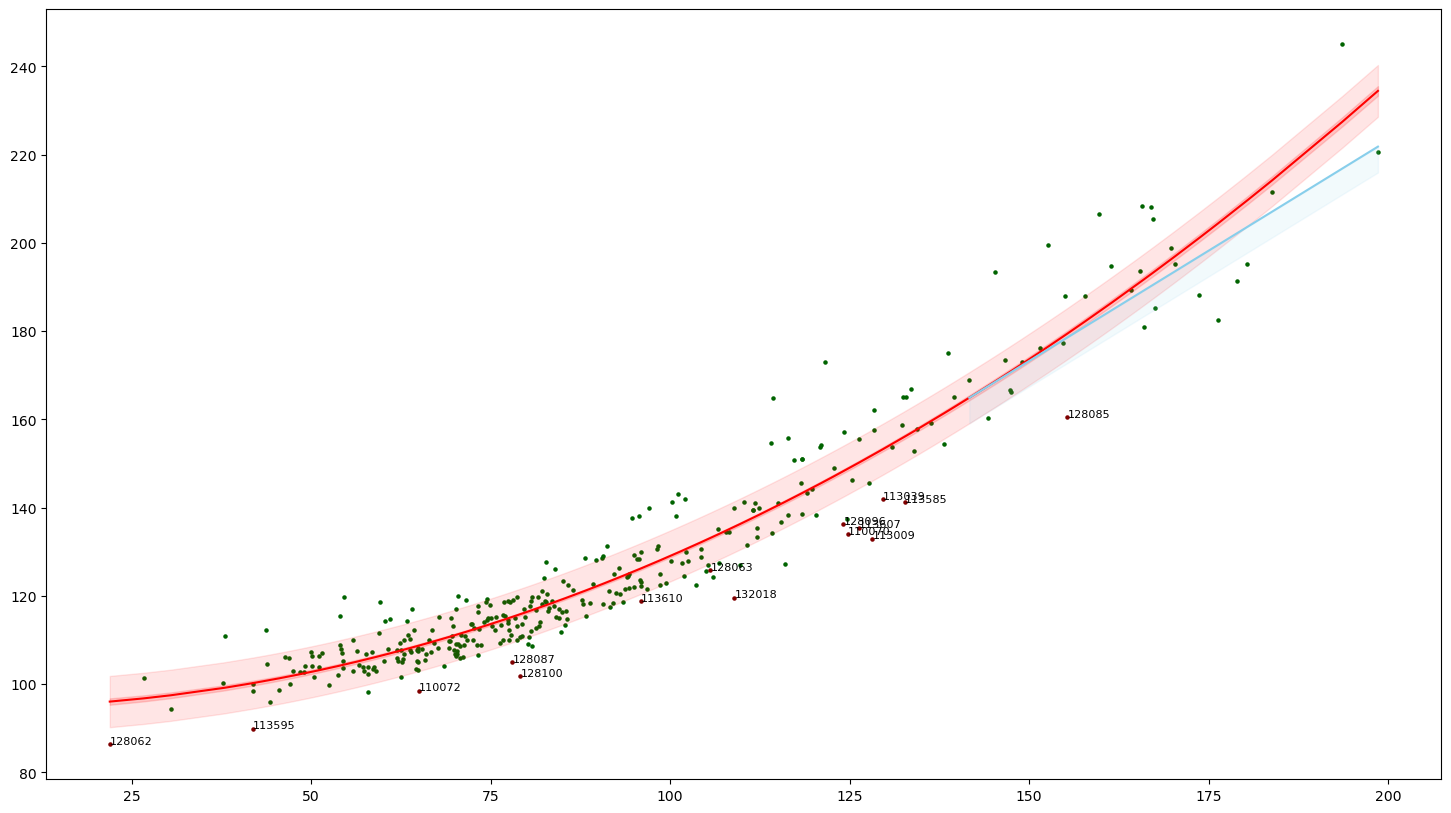

In [38]:
db_df = double_low_arbitrage(data,redeem_df,put_df)
my_df,db_buy_dict = buy_sell_db(db_df,'mycb_list.csv',show_price=True)
lp_df = low_premium_arbitrage(db_df)

In [39]:
lp_df[(lp_df['value'] < 200) & (lp_df['value'] > 180)]

,name,value,price,premium,db_low,lower_deviation,fit_price,low_fit_price,upper_fit_price
id,,,,,,,,,
128103,同德转债,180.382844,195.100,8.158844,203.258844,-1.350898,203.605927,197.771693,209.440160
123103,震安转债,198.578613,220.639,11.109145,231.748145,2.176252,221.801696,215.939611,227.663781
113537,文灿转债,183.846303,211.600,15.096141,226.696141,5.153185,207.069385,201.230234,212.908536
127030,盛虹转债,193.629956,244.998,26.528976,271.526976,16.113335,216.853038,210.999020,222.707057


In [40]:
lp_df.loc['128063']

name                     未来转债
value              105.563521
price                 125.849
premium             19.216373
db_low             145.065373
lower_deviation     -1.147844
fit_price          133.083249
low_fit_price      127.310324
upper_fit_price    138.856175
Name: 128063, dtype: object

In [41]:
buy_sell_low(lp_df,db_buy_dict,'mycb_list.csv',show_price=True)

118002 天合转债 not in lists

Add  113009 广汽转债 132.96 136.712 3.752 -8.988
Add  132018 G三峡EB1 119.6 129.379 9.779 -7.919
Add  128085 鸿达转债 160.438 163.722 3.284 -7.601
Add  128100 搜特转债 101.842 127.672 28.715 -7.467
Add  110070 凌钢转债 134.01 141.449 7.439 -6.292
Add  113607 伟20转债 135.44 142.718 7.278 -6.184

Strong Buy 113009 广汽转债 132.96 136.712 3.752 -8.988
Strong Buy 132018 G三峡EB1 119.6 129.379 9.779 -7.919
Strong Buy 128100 搜特转债 101.842 127.672 28.715 -7.467
Strong Buy 110070 凌钢转债 134.01 141.449 7.439 -6.292
Strong Buy 113607 伟20转债 135.44 142.718 7.278 -6.184
Strong Buy 110033 国贸转债 127.16 136.853 9.693 -6.128
Buy 132014 18中化EB 182.5 186.028 3.528 -5.770
Strong Buy 128087 孚日转债 105.0 138.127 34.579 -4.068
Buy 123068 弘信转债 137.3 147.511 10.211 -3.901
Strong Buy 113577 春秋转债 126.98 142.714 15.734 -2.686


In [42]:
df2 = lp_df.sort_values('lower_deviation')
df2[0:30]

,name,value,price,premium,db_low,lower_deviation,fit_price,low_fit_price,upper_fit_price
id,,,,,,,,,
113009,广汽转债,128.151780,132.960,3.751973,136.711973,-8.988491,151.873720,146.091414,157.656027
132018,G三峡EB1,108.946074,119.600,9.779082,129.379082,-7.918897,135.659323,129.885499,141.433147
128085,鸿达转债,155.336537,160.438,3.284136,163.722136,-7.600933,179.440055,173.635953,185.244156
128100,搜特转债,79.121851,101.842,28.715391,127.672068,-7.466904,115.832147,110.060080,121.604213
110070,凌钢转债,124.730723,134.010,7.439448,141.449448,-6.291617,148.787857,143.007483,154.568232
113607,伟20转债,126.251325,135.440,7.278082,142.718082,-6.183990,150.148894,144.367684,155.930105
110033,国贸转债,115.923223,127.160,9.693293,136.853293,-6.128145,141.237504,135.461263,147.013744
113585,寿仙转债,132.664522,141.200,6.433882,147.633882,-6.048438,156.075343,150.290211,161.860475
132014,18中化EB,176.281471,182.500,3.527614,186.027614,-5.770417,199.504553,193.675908,205.333198


In [43]:
my_df

,name,price,db_low
id,,,
128100,搜特转债,101.842,127.672068
132018,G三峡EB1,119.600,129.379082
113009,广汽转债,132.960,136.711973
128087,孚日转债,105.000,138.127410
110070,凌钢转债,134.010,141.449448
113610,灵康转债,118.840,142.528962
113607,伟20转债,135.440,142.718082
128063,未来转债,125.849,145.065373
128096,奥瑞转债,136.190,145.937417


today quartile 157.94646099706745


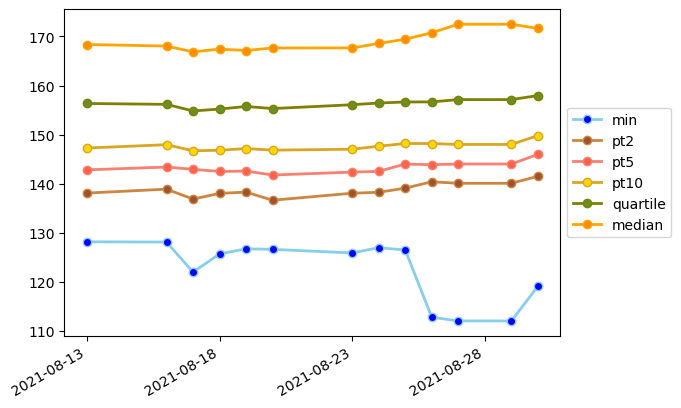

In [44]:
save_historical_data(db_df,'db_low','db_history.csv')
plot_history('db_history.csv')

today quartile 26.170237331296132


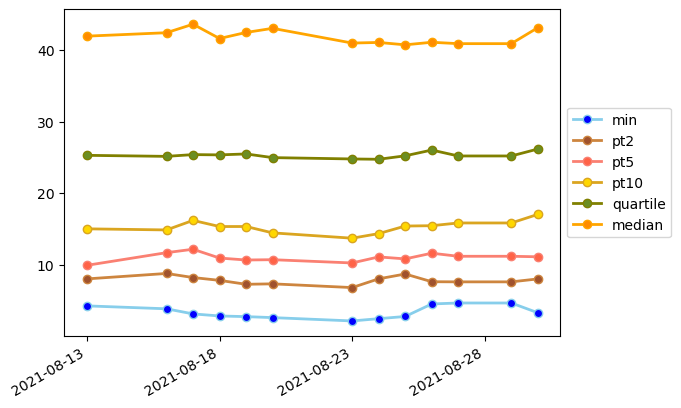

In [45]:
save_historical_data(lp_df,'premium','premium_history.csv')
plot_history('premium_history.csv')

today quartile 110.0


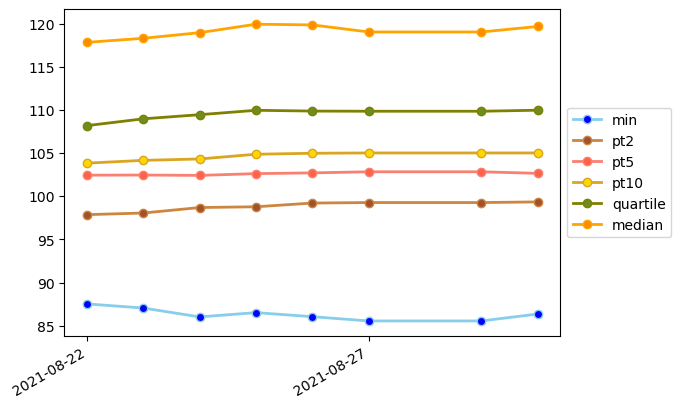

In [46]:
save_historical_data(db_df,'price','price_history.csv')
plot_history('price_history.csv')

In [47]:
db_df[0:10]

,name,stock_id,stock_name,price,convert_value,premium_rt,rating_cd,pb,convert_amt_ratio,convert_amt_ratio2,...,redeem_price,last_time,force_redeem,redeem_dt,force_redeem_price,redeem_CAGR,put_CAGR,new_convert_value,new_premium,db_low
id,,,,,,,,,,,,,,,,,,,,,
113508,新凤转债,603225.ss,新凤鸣,117.830,119.30,-1.23%,AA,1.93,2.1%,2.1%,...,108.000,2.655,Y,2021-08-31,20.34,0.000000,0.000000,116.384226,0.012422,119.072242
128100,搜特转债,002503.sz,搜于特,101.842,94.44,7.83%,A,1.36,20.5%,16.9%,...,112.000,4.532,X,None,2.11,0.028853,0.002372,79.121851,0.287154,127.672068
132018,G三峡EB1,600900.ss,长江电力,119.600,114.04,5.05%,AAA,2.48,4.1%,4.1%,...,108.000,2.611,X,None,20.09,0.000000,0.000000,108.946074,0.097791,129.379082
113009,广汽转债,601238.ss,广汽集团,132.960,131.35,1.22%,AAA,2.19,1.9%,1.3%,...,106.000,0.397,X,None,18.16,0.000000,0.000000,128.151780,0.037520,136.711973
110033,国贸转债,600755.ss,厦门国贸,127.160,126.64,0.41%,AAA,0.60,7.3%,6.9%,...,108.000,0.351,X,None,8.74,0.000000,0.000000,115.923223,0.096933,136.853293
128087,孚日转债,002083.sz,孚日股份,105.000,90.44,16.09%,AA-,1.00,17.6%,17.6%,...,108.000,4.301,X,None,5.85,0.014517,0.000000,78.021047,0.345791,138.127410
128108,蓝帆转债,002382.sz,蓝帆医疗,122.500,112.23,9.15%,AA,1.62,7.4%,7.4%,...,108.000,4.742,N,None,23.71,0.000000,0.000000,103.624006,0.182159,140.715851
110070,凌钢转债,600231.ss,凌钢股份,134.010,128.25,4.49%,AA,1.14,2.2%,2.2%,...,112.000,4.619,X,None,3.50,0.000000,0.000000,124.730723,0.074394,141.449448
113541,荣晟转债,603165.ss,荣晟环保,124.240,111.99,10.94%,AA-,1.83,5.1%,5.1%,...,110.000,3.896,X,None,14.09,0.000000,0.000000,105.939288,0.172747,141.514717


In [48]:
db_df[10:20]

,name,stock_id,stock_name,price,convert_value,premium_rt,rating_cd,pb,convert_amt_ratio,convert_amt_ratio2,...,redeem_price,last_time,force_redeem,redeem_dt,force_redeem_price,redeem_CAGR,put_CAGR,new_convert_value,new_premium,db_low
id,,,,,,,,,,,,,,,,,,,,,
113610,灵康转债,603669.ss,灵康药业,118.840,103.02,15.36%,AA-,4.50,7.2%,7.2%,...,115.000,5.255,X,None,11.19,0.002238,0.0,95.906214,0.239127,142.528962
113577,春秋转债,603890.ss,春秋电子,126.980,114.36,11.03%,AA-,2.82,3.7%,3.3%,...,112.000,4.622,N,None,14.12,0.000000,0.0,109.717501,0.157336,142.713587
113607,伟20转债,603568.ss,伟明环保,135.440,131.74,2.81%,AA,6.22,3.3%,3.3%,...,110.000,5.175,X,None,28.22,0.000000,0.0,126.251325,0.072781,142.718082
123002,国祯转债,300388.sz,节能国祯,111.690,88.52,26.18%,AA,1.42,4.9%,4.9%,...,106.000,2.236,X,None,10.87,0.000000,0.0,84.840079,0.316477,143.337686
128037,岩土转债,002542.sz,中化岩土,108.999,90.97,19.82%,AA,1.24,14.7%,11.8%,...,108.000,2.542,X,None,4.03,0.002004,0.0,80.239853,0.358415,144.640082
128063,未来转债,002631.sz,德尔未来,125.849,117.33,7.26%,AA-,3.74,9.5%,9.4%,...,120.000,3.595,X,None,11.18,0.000000,0.0,105.563521,0.192164,145.065373
128133,奇正转债,002287.sz,奇正藏药,117.350,96.34,21.81%,AA,4.44,5.3%,5.3%,...,112.000,5.063,X,None,38.71,0.000000,0.0,91.659831,0.280277,145.377729
113536,三星转债,603578.ss,三星新材,125.690,113.81,10.44%,AA,2.56,7.4%,7.4%,...,110.000,3.751,X,None,17.89,0.000000,0.0,104.969529,0.197395,145.429510
113030,东风转债,601515.ss,东风股份,118.620,96.59,22.81%,AA,1.78,3.5%,3.5%,...,112.000,4.318,X,None,8.38,0.000000,0.0,93.431411,0.269594,145.579444


In [49]:
lp_df[0:20]

,name,value,price,premium,db_low,lower_deviation,fit_price,low_fit_price,upper_fit_price
id,,,,,,,,,
113009,广汽转债,128.151780,132.960,3.751973,136.711973,-8.988491,151.873720,146.091414,157.656027
132018,G三峡EB1,108.946074,119.600,9.779082,129.379082,-7.918897,135.659323,129.885499,141.433147
128085,鸿达转债,155.336537,160.438,3.284136,163.722136,-7.600933,179.440055,173.635953,185.244156
128100,搜特转债,79.121851,101.842,28.715391,127.672068,-7.466904,115.832147,110.060080,121.604213
110070,凌钢转债,124.730723,134.010,7.439448,141.449448,-6.291617,148.787857,143.007483,154.568232
113607,伟20转债,126.251325,135.440,7.278082,142.718082,-6.183990,150.148894,144.367684,155.930105
110033,国贸转债,115.923223,127.160,9.693293,136.853293,-6.128145,141.237504,135.461263,147.013744
113585,寿仙转债,132.664522,141.200,6.433882,147.633882,-6.048438,156.075343,150.290211,161.860475
132014,18中化EB,176.281471,182.500,3.527614,186.027614,-5.770417,199.504553,193.675908,205.333198


In [50]:
print(np.percentile(db_df['db_low'],50))
print(np.percentile(db_df['price'],50))
print(np.percentile(lp_df['premium'],50))

171.63836959039654
119.72
43.13039058612171


In [51]:
lp_df[(lp_df['value'] < 30) & (lp_df['price']>70)]

,name,value,price,premium,db_low,lower_deviation,fit_price,low_fit_price,upper_fit_price
id,,,,,,,,,
128062,亚药转债,21.934456,86.35,293.672861,369.702728,-4.287707,96.025773,90.218297,101.833248
132011,17浙报EB,26.679040,101.28,279.623861,379.142329,11.350865,96.758349,90.955737,102.560962


In [52]:
put_df[0:10]

,name,stock_id,stock_name,price,convert_value,premium_rt,rating_cd,pb,convert_amt_ratio,convert_amt_ratio2,...,put_convert_price,maturity_dt,redeem_price,last_time,force_redeem,redeem_dt,force_redeem_price,actual_put_price,CAGR,last_to_put
id,,,,,,,,,,,,,,,,,,,,,
128062,亚药转债,002370.sz,亚太药业,86.350,24.74,249.05%,BB,3.39,51.7%,44.6%,...,11.38,2025-04-02,115.000,3.592,X,None,21.12,102.00,0.103201,1.695890
113595,花王转债,603007.ss,ST花王,89.880,47.83,87.91%,BBB+,0.95,29.9%,29.7%,...,4.84,2026-07-20,116.000,4.890,X,None,9.00,102.64,0.045244,3.000000
113017,吉视转债,601929.ss,吉视传媒,99.680,61.36,62.46%,AA+,0.81,27.7%,27.7%,...,2.06,2023-12-27,106.000,2.326,X,None,3.83,101.04,0.032006,0.430137
113596,城地转债,603887.ss,城地香江,94.280,34.67,171.97%,AA-,0.92,40.3%,31.7%,...,16.98,2026-07-27,108.000,4.910,X,None,31.54,102.48,0.028008,3.019178
113576,起步转债,603557.ss,ST起步,96.030,46.45,106.76%,A,1.50,11.0%,11.0%,...,7.38,2026-04-09,115.000,4.611,N,None,13.71,103.04,0.026290,2.715068
128044,岭南转债,002717.sz,岭南股份,98.674,50.08,97.01%,AA-,1.01,19.8%,14.6%,...,4.14,2024-08-14,107.000,2.959,X,None,7.68,101.20,0.024127,1.060274
128127,文科转债,002775.sz,文科园林,98.298,83.20,18.15%,AA-,0.84,52.4%,45.6%,...,3.42,2026-08-19,115.000,4.973,X,None,6.34,102.64,0.014148,3.076712
113589,天创转债,603608.ss,天创时尚,98.380,46.70,110.64%,AA,1.46,24.4%,24.4%,...,8.60,2026-06-23,110.000,4.816,X,None,15.98,102.48,0.014065,2.923288
110072,广汇转债,600297.ss,广汇汽车,98.490,71.71,37.34%,AA+,0.56,14.4%,14.4%,...,2.82,2026-08-17,110.000,4.967,X,None,5.24,102.00,0.011447,3.076712


In [53]:
time_decay_factor = 0.25

In [54]:
def func(X, a, b, c, d):
    x,y = X
    return a * x ** 2 + b * x +  c * y ** time_decay_factor + d 

In [55]:
def three_factor_arbitrage(db_df): 
    import scipy.stats as stats
    from scipy.optimize import curve_fit
    
    ids = []
    names = []
    db_lows = []
    values = []
    prices = []
    times = []
    expires = []
    for cb_id in db_df.index:
        name = db_df['name'][cb_id]
        price = db_df['price'][cb_id]
        value = db_df['new_convert_value'][cb_id]
        premium = db_df['new_premium'][cb_id]
        db_low = db_df['db_low'][cb_id]
        force_redeem = db_df['force_redeem'][cb_id]
        today = date.today()
        time_to_exp = 0
        expire_dt = today
        if(force_redeem != "Y"):
            maturity_dt  = db_df['maturity_dt'][cb_id]
            expire_dt = maturity_dt
            maturity_dt = datetime.strptime(maturity_dt,'%Y-%m-%d').date()
            days_interval = maturity_dt-today
            time_to_exp = days_interval.days/365
        else:
            #continue
            redeem_dt    = db_df['redeem_dt'][cb_id]
            expire_dt = redeem_dt
            if(redeem_dt == None):
                time_to_exp = 30/365 ####1 month to be forced redeem
            else:
                redeem_dt = datetime.strptime(redeem_dt,'%Y-%m-%d').date()
                days_interval = redeem_dt-today
                time_to_exp = days_interval.days/365
        
        if(price>120 and price/value>1.6):
            #print("remove premium outlier %s %.3f %.3f"%(name,value,price))
            continue
        if(value>200):
            #print("remove price over 200 %s %.3f %.3f"%(name,value,price))
            continue
        ids.append(cb_id)
        names.append(name)
        db_lows.append(db_low)
        values.append(value)
        prices.append(price)
        times.append(time_to_exp)
        expires.append(expire_dt)

    ids = np.array(ids)
    names = np.array(names)
    db_lows = np.array(db_lows)
    values  = np.array(values)
    times   = np.array(times)
    prices  = np.array(prices)
    expires = np.array(expires)
    x = values
    y = times
    z = prices
    indexes = np.argsort(x)
    x = x[indexes]
    y = y[indexes]
    z = z[indexes]
    ids = ids[indexes]
    names = names[indexes]
    db_lows = db_lows[indexes]
    expires = expires[indexes]
    values  = x
    times   = y
    prices  = z
    
    popt, pcov = curve_fit(func,(x,y),z)
    print(popt)
    limit_value = (1-popt[1])/2/popt[0]
    intercept = popt[0] * limit_value**2 + popt[1]* limit_value - limit_value
    print(limit_value)
    zfit = func((x,y), *popt)

    n = len(x)
    resid = z - zfit
    s_err = np.sqrt(np.sum(resid**2)/(n - 2))  # standard deviation of the error (residuals)
    # Confidence interval for the linear fit:
    t = stats.t.ppf(0.8, n - 2)
    ci = t * s_err * np.sqrt(1/n + (x - np.mean(x))**2/np.sum((x-np.mean(x))**2))
    # Prediction interval for the linear fit:
    pi = t * s_err * np.sqrt(1 + 1/n + (x - np.mean(x))**2/np.sum((x-np.mean(x))**2))

    #convert_value_limit = (1-coef[1])/2/coef[0]
    #price_limit = poly(convert_value_limit)
    #xext = np.linspace(convert_value_limit,max(x))
    #yext = xext+price_limit-convert_value_limit
    #ext_index = np.argmax(x>=convert_value_limit)
    #xext = x[ext_index:]
    #yext = xext+price_limit-convert_value_limit
    #piext = pi[ext_index:]

    td_data = []
    se = 0
    for i,cb_id in enumerate(ids):
        cb_name = names[i]
        db_low  = db_lows[i]
        value      = values[i]
        time_to_exp = times[i]
        expire_dt  = expires[i]
        price = prices[i]
        premium = price/value-1
        fit_price = zfit[i]
        if(value>limit_value):
            fit_price = value+intercept + popt[2] * time_to_exp ** time_decay_factor + popt[3]
        se += (fit_price-price)**2
        deviation = price/(fit_price)*100-100
        item = {'id':cb_id,'name':cb_name,'value': value,'time_to_exp':time_to_exp,'price':price,
                'premium':premium,'db_low':db_low, 'deviation':deviation,
                'fit_price':fit_price,'expire_dt':expire_dt}
        td_data.append(item)
        #plt.rcParams["figure.figsize"] = (18,10)
        #if cb_id in my_df.index:
        #if price<yfit[i]-pi[i]:
        #    plt.scatter(x[i], y[i], marker='o', s=5,color='maroon')
        #    plt.text(x[i]+.03, y[i]+.03, cb_id, fontsize=8)
        #else:
        #    plt.scatter(x[i], y[i], marker='o', s=5,color='darkgreen')
            

    td_df = pd.DataFrame(td_data)
    td_df = td_df.set_index(['id'])
    td_df = td_df.sort_values('deviation')
    #plt.plot(x,yfit,color='red')
    #plt.plot(xext,yext,color='skyblue')
    #plt.fill_between(x, yfit-ci, yfit+ci,color=[1, 0, 0, 0.15])
    #plt.fill_between(x, yfit-pi, yfit+pi,color=[1, 0, 0, 0.1])
    #plt.fill_between(xext, yext-piext, yext,color='skyblue',alpha=0.1)
    #plt.plot(x,yfit)
    mse = np.square(resid).mean()
    print("mse=%.3f"%mse)
    mse2 = se/n
    print("adjuse mse=%.3f"%mse2)
    #plt.show()
    #plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
    return popt,td_df
    #return x,y

In [56]:
def buy_sell_three(td_df,file,show_price=False):
    total_number = len(td_df)
    quartile = np.percentile(td_df['deviation'],25) ##first quartile
    tenthtile = np.percentile(td_df['deviation'],10) ##10th percentile
    buy_number  = int(total_number*0.05) ##5th percentile
    add_number = int(total_number*0.02)  ##2th percentile
    
    buy_dict = {i:td_df['name'][i] for i in td_df[0:buy_number].index}
    add_dict = {i:td_df['name'][i] for i in td_df[0:add_number].index}
    sell_count = 0
    holding_dict = dict()
    
    ##sell
    my_list = []
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            cb_id,cb_name,category = row
            if cb_id not in td_df.index:
                print("%s %s %s"%(cb_id,cb_name,'not in lists'))
                sell_count += 1
                continue
            holding_dict[cb_id] = cb_name
            price = td_df.loc[cb_id]['price']
            time_to_exp  = td_df.loc[cb_id]['time_to_exp']
            premium = td_df.loc[cb_id]['premium']
            deviation = td_df.loc[cb_id]['deviation']
            fit_price = td_df.loc[cb_id]['fit_price']
            item = td_df.loc[cb_id]
            my_list.append(item)
            if deviation > tenthtile:
                sell = "Sell"
                if(deviation>quartile):
                    sell = "Strong Sell"
                if(show_price):
                    print("%s %s %s %s %.3f %.3f %.3f"
                          %(sell,cb_id,cb_name,time_to_exp,price,premium,deviation))
                else:
                    print("%s %s %s"%(sell,cb_id,cb_name))
                sell_count += 1
    if(sell_count==0):
        print('No CB to sell')
        
    ##buy
    print()
    for cb_id,cb_name in add_dict.items():
        price = td_df.loc[cb_id]['price']
        time_to_exp  = td_df.loc[cb_id]['time_to_exp']
        premium = td_df.loc[cb_id]['premium']
        deviation = td_df.loc[cb_id]['deviation']
        if(show_price):
            print("Add  %s %s %s %.3f %.3f %.3f"
                  %(cb_id,cb_name,time_to_exp,price,premium,deviation))
        else:
            print("Add  %s %s"%(cb_id,cb_name))
    print()
    for cb_id,cb_name in buy_dict.items():
        price = td_df.loc[cb_id]['price']
        time_to_exp  = td_df.loc[cb_id]['time_to_exp']
        premium = td_df.loc[cb_id]['premium']
        deviation = td_df.loc[cb_id]['deviation']
        if cb_id not in holding_dict.keys():
            if(show_price):
                print("Buy %s %s %s %.3f %.3f %.3f"
                      %(cb_id,cb_name,time_to_exp,price,premium,deviation))
            else:
                print("Buy  %s %s"%(cb_id,cb_name))
        else:
            print("Have %s %s %s %.3f %.3f %.3f"
                      %(cb_id,cb_name,time_to_exp,price,premium,deviation))
    
    #my_df = pd.DataFrame(my_list)
    #my_df = my_df.set_index(['id'])
    #my_df = my_df.sort_values('premium',ascending=True)
    #return my_df
    

In [57]:
# 0.01 43.179
# 0.1 43.288 43.682
# 0.2 43.351
# 0.25 43.468 43.871
# 0.3 43.488
# 0.4 43.624
# 0.5 43.791  44.217

In [58]:
#x,y = three_factor_arbitrage(db_df)
popt,td_df = three_factor_arbitrage(db_df)

[ 3.69471655e-03 -3.81302895e-02  1.29960439e+01  7.72367889e+01]
140.48848878523293
mse=44.809
adjuse mse=44.915


In [59]:
 buy_sell_three(td_df,'mycb_list.csv',show_price=True)

118002 天合转债 not in lists

Add  128100 搜特转债 4.531506849315068 101.842 0.287 -12.440
Add  113595 花王转债 4.890410958904109 89.880 1.148 -11.393
Add  132018 G三峡EB1 2.610958904109589 119.600 0.098 -10.383
Add  110072 广汇转债 4.967123287671233 98.490 0.515 -10.275
Add  113607 伟20转债 5.175342465753425 135.440 0.073 -10.255
Add  128062 亚药转债 3.591780821917808 86.350 2.937 -10.117

Have 128100 搜特转债 4.531506849315068 101.842 0.287 -12.440
Have 113595 花王转债 4.890410958904109 89.880 1.148 -11.393
Have 132018 G三峡EB1 2.610958904109589 119.600 0.098 -10.383
Have 110072 广汇转债 4.967123287671233 98.490 0.515 -10.275
Have 113607 伟20转债 5.175342465753425 135.440 0.073 -10.255
Have 128062 亚药转债 3.591780821917808 86.350 2.937 -10.117
Have 110070 凌钢转债 4.619178082191781 134.010 0.074 -10.069
Have 128085 鸿达转债 4.298630136986302 160.438 0.033 -10.050
Have 113585 寿仙转债 4.7753424657534245 141.200 0.064 -9.728
Have 128087 孚日转债 4.301369863013699 105.000 0.346 -9.066
Have 128096 奥瑞转债 4.454794520547945 136.190 0.097 -8.155
Buy 12

In [60]:
td_df[0:20]

,name,value,time_to_exp,price,premium,db_low,deviation,fit_price,expire_dt
id,,,,,,,,,
128100,搜特转债,79.121851,4.531507,101.842,0.287154,127.672068,-12.440094,116.311226,2026-03-11
113595,花王转债,41.845591,4.890411,89.880,1.147897,198.466222,-11.393363,101.437097,2026-07-20
132018,G三峡EB1,108.946074,2.610959,119.600,0.097791,129.379082,-10.382576,133.456190,2024-04-09
110072,广汇转债,64.998136,4.967123,98.490,0.515274,147.132935,-10.275433,109.769267,2026-08-17
113607,伟20转债,126.251325,5.175342,135.440,0.072781,142.718082,-10.254796,150.916143,2026-11-01
128062,亚药转债,21.934456,3.591781,86.350,2.936729,369.702728,-10.116865,96.069190,2025-04-02
110070,凌钢转债,124.730723,4.619178,134.010,0.074394,141.449448,-10.069320,149.014775,2026-04-12
128085,鸿达转债,155.336537,4.298630,160.438,0.032841,163.722136,-10.050063,178.363660,2025-12-16
113585,寿仙转债,132.664522,4.775342,141.200,0.064339,147.633882,-9.728106,156.416348,2026-06-08


In [61]:
func((184,5.4), *popt)

215.120285694257

In [62]:
td_df.loc['113009']

name                 广汽转债
value           128.15178
time_to_exp       0.39726
price              132.96
premium           0.03752
db_low         136.711973
deviation         -7.2453
fit_price      143.345836
expire_dt      2022-01-22
Name: 113009, dtype: object

In [63]:
lp_df.loc['113009']

name                     广汽转债
value               128.15178
price                  132.96
premium              3.751973
db_low             136.711973
lower_deviation     -8.988491
fit_price           151.87372
low_fit_price      146.091414
upper_fit_price    157.656027
Name: 113009, dtype: object